# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

# EDA Summary:

- No duplicated rows
- 8 features with missing values (`scheme_name` is 35% missing)

#### Target Variable
- `status_group` - Target Variable (3 categories)
	- Consider preprocessing for class imbalance

## Changes Needed BEFORE Data Split

#### Dropped Features
- `num_private` -
	- Can drop from dataset
- `recorded_by` - Group entering this row of data
	- All the same company; drop feature

#### Numeric Features
- `amount_tsh` - Total static head (amount water available to waterpoint)
	- Log transformation (np.log1p is fine)
- `population` - Population around the well
	- np.log1p transformation looks great
- **Note:** try without first if using DT, RF, CatBoost, LGBM

#### Date Features
- `date_recorded` - The date the row was entered
	- Convert to pd.datetime(); likely can drop feature
- `construction_year` - Year the waterpoint was constructed
	- ~35% of values have year = 0; consider turning into categorical

## Changes Needed AFTER Data Split

### Categorical Features
- `funder` - Who funded the well
	- Includes na and 0 values
	- 0 values in `funder` and `installer` are the same in test_features and train_features
- `gps_height` - Altitude of the well
	- Looks fairly balanced between `status_groups`; no change needed
- `installer` - Organization that installed the well
	- Includes na and 0 values: combine with 0
- `longitude` - GPS coordinate
	- Some 0 values (which would not exist in Tanzania)
	- Perhaps it's best to leave as all missing values have the same value
- `latitude` - GPS coordinate
	- Refer to longitude
- `wpt_name` - Name of the waterpoint if there is one
	- Most common value is 'none'
	- Convert missing values to 'unknown' (only 2)
- `subvillage` - Geographic location
	- Some categories as single letters or numbers. Rename missing values to 'unknown'
- `region_code` - Geographic location (coded)
	- Convert to categorical
- `district_code` - Geographic location (coded)
	- Convert to categorical
- `public_meeting` - True/False
	- Has missing values; convert to 'unknown' (boolean)
- `scheme_management` - Who operates the waterpoint
	- Convert missing values to 'unknown'
- `scheme_name` - Who operates the waterpoint
	- Convert missing values to 'unknown'
- `permit` - If the waterpoint is permitted
	- Convert missing values to 'unknown' (boolean)

### No Changes Needed (Categorical Features)
- `basin` - Geographic water basin
- `region` - Geographic location
- `lga` - Geographic location
- `ward` - Geographic location
- `extraction_type` - The kind of extraction the waterpoint uses
- `extraction_type_group` - The kind of extraction the waterpoint uses
- `management` - How the waterpoint is managed
- `management_group` - How the waterpoint is managed
- `payment` - What the water costs
- `payment_type` - What the water costs
- `water_quality` - The quality of the water
- `quality_group` - The quality of the water
- `quantity` - The quantity of water
- `quantity_group` - The quantity of water
- `source` - The source of the water
- `source_type` - The source of the water
- `source_class` - The source of the water
- `waterpoint_type` - The kind of waterpoint
- `waterpoint_type_group` - The kind of waterpoint

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
! pip install category_encoders

from category_encoders import TargetEncoder

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.2 MB/s eta 0:00:00


In [3]:
# Load data
train_label = pd.read_csv('data/train_labels.csv')
train_features = pd.read_csv('data/train_values.csv')
test_features = pd.read_csv('data/test_values.csv')
submission = pd.read_csv('data/SubmissionFormat.csv')

In [4]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

id  amount_tsh  ... waterpoint_type_group    status_group
0  69572      6000.0  ...    communal standpipe      functional
1   8776         0.0  ...    communal standpipe      functional
2  34310        25.0  ...    communal standpipe      functional
3  67743         0.0  ...    communal standpipe  non functional
4  19728         0.0  ...    communal standpipe      functional

[5 rows x 41 columns]

# Additional EDA
Look at unique values that may exist in `test_features` that doesn't exist in `train_features`

In [5]:
omit_cols = ['id', 'amount_tsh', 'gps_height', 'longitude', 
             'latitude', 'num_private', 'population', 'status_group']

# Convert 'region_code' and 'district_code' to object dtype
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')

# Filter out columns in omit_cols that exist in the DataFrame
omit_cols_train = [col for col in omit_cols if col in train_df.columns]
omit_cols_test = [col for col in omit_cols if col in test_features.columns]

train_filtered = train_df.drop(columns=omit_cols_train)
test_filtered = test_features.drop(columns=omit_cols_test)

# Create a table that counts the unique values in each feature in train_filtered and compares them to the counts of unique values in test_filtered

# Initialize a list to store the results
unique_counts = []

# Iterate over the columns in train_filtered
for column in train_filtered.columns:
    # Count unique values in train_filtered and test_filtered
    train_unique_count = train_filtered[column].nunique()
    test_unique_count = test_filtered[column].nunique()
    
    # Append the results to the list
    unique_counts.append({
        'feature': column,
        'train': train_unique_count,
        'test': test_unique_count
    })

# Convert the list to a DataFrame
unique_counts_df = pd.DataFrame(unique_counts)

unique_counts_df

feature  train   test
0           date_recorded    356    331
1                  funder   1896    979
2               installer   2145   1091
3                wpt_name  37399  10840
4                   basin      9      9
5              subvillage  19287   8443
6                  region     21     21
7             region_code     27     26
8           district_code     20     20
9                     lga    125    125
10                   ward   2092   1959
11         public_meeting      2      2
12            recorded_by      1      1
13      scheme_management     11     11
14            scheme_name   2695   1788
15                 permit      2      2
16      construction_year     55     55
17        extraction_type     18     17
18  extraction_type_group     13     13
19  extraction_type_class      7      7
20             management     12     12
21       management_group      5      5
22                payment      7      7
23           payment_type      7      7
24          water_quality      8      8
25          quality_group      6      6
26               quantity      5      5
27         quantity_group      5      5
28                 source     10     10
29            source_type      7      7
30           source_class      3      3
31        waterpoint_type      7      7
32  waterpoint_type_group      6      6

In [6]:
def unique_value_count(feature_name, num_counts):
    # Assuming 'train_filtered' is another DataFrame with a similar structure to 'test_filtered'
    unique_values_test = set(test_filtered[feature_name].unique())
    unique_values_train = set(train_filtered[feature_name].unique())

    # Find values that are in test_filtered but not in train_filtered
    unique_values_in_test_not_in_train = unique_values_test - unique_values_train

    # Filter test_filtered to include only rows with these unique values
    filtered_test = test_filtered[test_filtered[feature_name].isin(unique_values_in_test_not_in_train)]

    # Show the value counts for these unique values
    return filtered_test[feature_name].value_counts().head(num_counts)

unique_value_count('funder', 10)

funder
Nakayama                      3
Pod                           2
Particular                    2
Jandu                         2
Cuso                          2
Ramadhan Dau                  2
Village Committee             2
Uniceffinidagermantanzania    2
Grail Mission                 2
Crdb                          2
Name: count, dtype: int64

In [7]:
unique_value_count('installer', 10)

installer
Water Board      3
Mohamed shiyo    3
DAWAS            3
FINWATER         3
Grail Mission    2
CRDB             2
CUSO             2
POD              2
Rotery C         2
KYASHA           2
Name: count, dtype: int64

In [8]:
unique_value_count('wpt_name', 10)

wpt_name
Rugunga          4
Kwa Abdala       4
Gisesa           3
Itete            3
Kwa Mfipa        3
Kwa Gozbert      3
Lukubanija       3
Kayanga          3
Kwa Olemutero    3
Kwa Majengo      3
Name: count, dtype: int64

# Preprocessing

### Outline
- Convert columns to object datatype and drop columns from both datasets
- Split dataset first to prevent data leakage
- Make necessary changes to both test and submission datasets
- Summarize changes in a function and use pipeline in next stage

In [9]:
# Convert 'region_code' and 'district_code' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')

# Try 'construction_year' as type 'object'
train_df['construction_year'] = train_df['construction_year'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

In [10]:
# Drop columns 'num_private' and 'recorded_by' (and 'id' from train_df)
train_df = train_df.drop(columns=['num_private', 'recorded_by', 'date_recorded', 'id'])
test_features = test_features.drop(columns=['num_private', 'recorded_by', 'date_recorded'])

## Split `train_df` into train and test sets before additional encoding to prevent data leakage

In [11]:
X = train_df.drop(columns='status_group', axis=1)
y = train_df['status_group']

# Split train_df into 70% train and 30% test, stratified by y ('status_group')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=604)

In [12]:
# Fill Categorical Columns with missing values in X_train, X_test, and test_features with 'unknown'
categorical_columns = X_train.select_dtypes(include=['object']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('unknown')
X_test[categorical_columns] = X_test[categorical_columns].fillna('unknown')
test_features[categorical_columns] = test_features[categorical_columns].fillna('unknown')

In [13]:
# The assert statement will raise an AssertionError if the condition is not met
# but it will not produce any output if the condition is true.

datasets = [X_train, X_test, test_features]

for df in datasets:
    assert df.isna().sum().sum() == 0, "There are missing values in the dataset"

## Let the Encoding Begin!

Base Steps:
- Convert values with less than 10 to 'Other'

1) Label Encoding (all categorical variables)
2) Label Encoding if over 20 categories; OHE if 20 or less.

In [35]:
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name' if less than 20
# Can increase value in future iterations

# Define the columns to be transformed
columns_to_transform = ['funder', 'installer', 'wpt_name']

# Function to replace infrequent categories with 'Other'
def replace_infrequent_categories(df, columns, threshold=20):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'Other')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

In [15]:
# Count number of categories per categorical column
from collections import defaultdict

# Function to count categories in each categorical column
def count_categories(df):
    category_counts = defaultdict(int)
    for column in df.select_dtypes(include=['object']).columns:
        category_counts[column] = df[column].nunique()
    return category_counts

# Get category counts for X_train, X_test, and test_features
category_counts_X_train = count_categories(X_train)
category_counts_X_test = count_categories(X_test)
category_counts_test_features = count_categories(test_features)

# Combine the counts into a single dataframe for easier inspection
combined_category_counts = pd.DataFrame({
    'X_train': pd.Series(category_counts_X_train),
    'X_test': pd.Series(category_counts_X_test),
    'test_features': pd.Series(category_counts_test_features)
})

combined_category_counts.sort_values(by='X_train', ascending=False)

X_train  X_test  test_features
subvillage               15991    9608           8444
scheme_name               2445    1880           1789
ward                      2074    1983           1959
funder                     333     184            172
installer                  320     184            164
wpt_name                   162      65             46
lga                        125     124            125
region                      21      21             21
extraction_type             18      18             17
extraction_type_group       13      13             13
management                  12      12             12
scheme_management           12      12             12
source                      10      10             10
basin                        9       9              9
water_quality                8       8              8
source_type                  7       7              7
payment_type                 7       7              7
waterpoint_type              7       7              7
extraction_type_class        7       7              7
payment                      7       7              7
quality_group                6       6              6
waterpoint_type_group        6       6              6
quantity                     5       5              5
quantity_group               5       5              5
management_group             5       5              5
permit                       3       3              3
source_class                 3       3              3
public_meeting               3       3              3

In [36]:
# Threshold for OneHotEncoding
threshold = 100

# Identify categorical features and their unique value counts
categorical_features = X_train.select_dtypes(include=['object']).columns
category_counts = X_train[categorical_features].nunique()

# Separate features based on the threshold
onehot_features = category_counts[category_counts < threshold].index.tolist()
labelencode_features = category_counts[category_counts >= threshold].index.tolist()

In [37]:
# Convert boolean features to strings
X_train[onehot_features] = X_train[onehot_features].astype(str)
X_test[onehot_features] = X_test[onehot_features].astype(str)

# Apply OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[onehot_features])
X_test_ohe = ohe.transform(X_test[onehot_features])

# Do the same for test_features
test_features[onehot_features] = test_features[onehot_features].astype(str)
test_features_ohe = ohe.transform(test_features[onehot_features])

In [39]:
# Apply Label Encoding
label_encoders = {}
for col in labelencode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))  # Convert to string
    # Use fit_transform on X_test to handle unseen labels
    X_test[col] = X_test[col].astype(str).map(lambda s: 'unknown' if s not in le.classes_ else s)  # Convert to string
    le.classes_ = np.append(le.classes_, 'unknown')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Combine OneHotEncoded and LabelEncoded features with numeric features
X_train_encoded = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(onehot_features))
X_test_encoded = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_train_final = pd.concat([X_train_encoded.reset_index(drop=True), X_train[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded.reset_index(drop=True), X_test[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)

print(f"Number of features after encoding: {X_train_final.shape[1]}")

Number of features after encoding: 256


In [40]:
# Label Encode for test_features
for col in labelencode_features:
    if col in test_features.columns:
        le = label_encoders[col]
        test_features[col] = test_features[col].map(
            lambda s: 'unknown' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, 'unknown')
        test_features[col] = le.transform(test_features[col])

In [41]:
test_features_encoded = pd.DataFrame(test_features_ohe, columns=ohe.get_feature_names_out(onehot_features))

test_features_final = pd.concat([test_features_encoded.reset_index(drop=True),
                                 test_features[labelencode_features + X.select_dtypes(
                                     include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)

Version 1: Label Encoding

In [22]:
'''

# Label Encoding
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    # Handle unseen labels in X_test by using a try-except block
    X_test[col] = X_test[col].astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le
    
# Apply the label encoders to test_features
for col in categorical_columns:
    if col in test_features.columns:
        le = label_encoders.get(col)
        if le:
            test_features[col] = test_features[col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
'''

'\n\n# Label Encoding\nlabel_encoders = {}\n\nfor col in categorical_columns:\n    le = LabelEncoder()\n    X_train[col] = le.fit_transform(X_train[col].astype(str))\n    # Handle unseen labels in X_test by using a try-except block\n    X_test[col] = X_test[col].astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)\n    label_encoders[col] = le\n    \n# Apply the label encoders to test_features\nfor col in categorical_columns:\n    if col in test_features.columns:\n        le = label_encoders.get(col)\n        if le:\n            test_features[col] = test_features[col].astype(str).apply(\n                lambda x: le.transform([x])[0] if x in le.classes_ else -1\n            )\n'

## Try Modeling w/o Tuning

#### Version 1 f1-scores:
| Model | Func / Repair / Non-func | Acc / M-Avg / W-Avg | Comp Score |
|-------|----------------------------------|---------------------------------|------------------|
| RF    | .84/.41/.80                      | .80/.68/.80                     | 0.7919           |
| CB    | .85/.37/.80                      | .80/.67/.79                     | 0.8064           |
| LGBM  | .84/.33/.79                      | .80/.67/.79                     | 0.7884           |
| DT    | .74/.30/.70                      | .69/.58/.69                     | n/a              |

#### Version 2:
| Model   | Accuracy | Precision (macro avg) | Recall (macro avg) | F1-Score (macro avg) | Comp Score |
|---------|----------|-----------------------|---------------------|----------------------|------------|
| RF  | 0.8019   | 0.726                 | 0.6638              | 0.6856               | 0.7875     |
| CB       | 0.7978   | 0.7477                | 0.6336              | 0.6604               | 0.7831     |
| DT  | 0.7251   | 0.6161                | 0.6225              | 0.6191               | n/a        |
| LGBM           | 0.7758   | 0.7684                | 0.5951              | 0.6253               | 0.7411     |



In [23]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [44]:
%%time
# RandomForestClassifier with max_depth=10
rf_model = RandomForestClassifier(random_state=42, max_depth=10)
rf_model.fit(X_train_final, y_train)
rf_preds = rf_model.predict(X_test_final)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

Random Forest Classification Report:
                          precision    recall  f1-score   support

             functional       0.70      0.96      0.81      9678
functional needs repair       0.65      0.05      0.10      1295
         non functional       0.90      0.57      0.69      6847

               accuracy                           0.74     17820
              macro avg       0.75      0.53      0.53     17820
           weighted avg       0.77      0.74      0.71     17820

CPU times: user 4.6 s, sys: 19.6 ms, total: 4.62 s
Wall time: 4.62 s


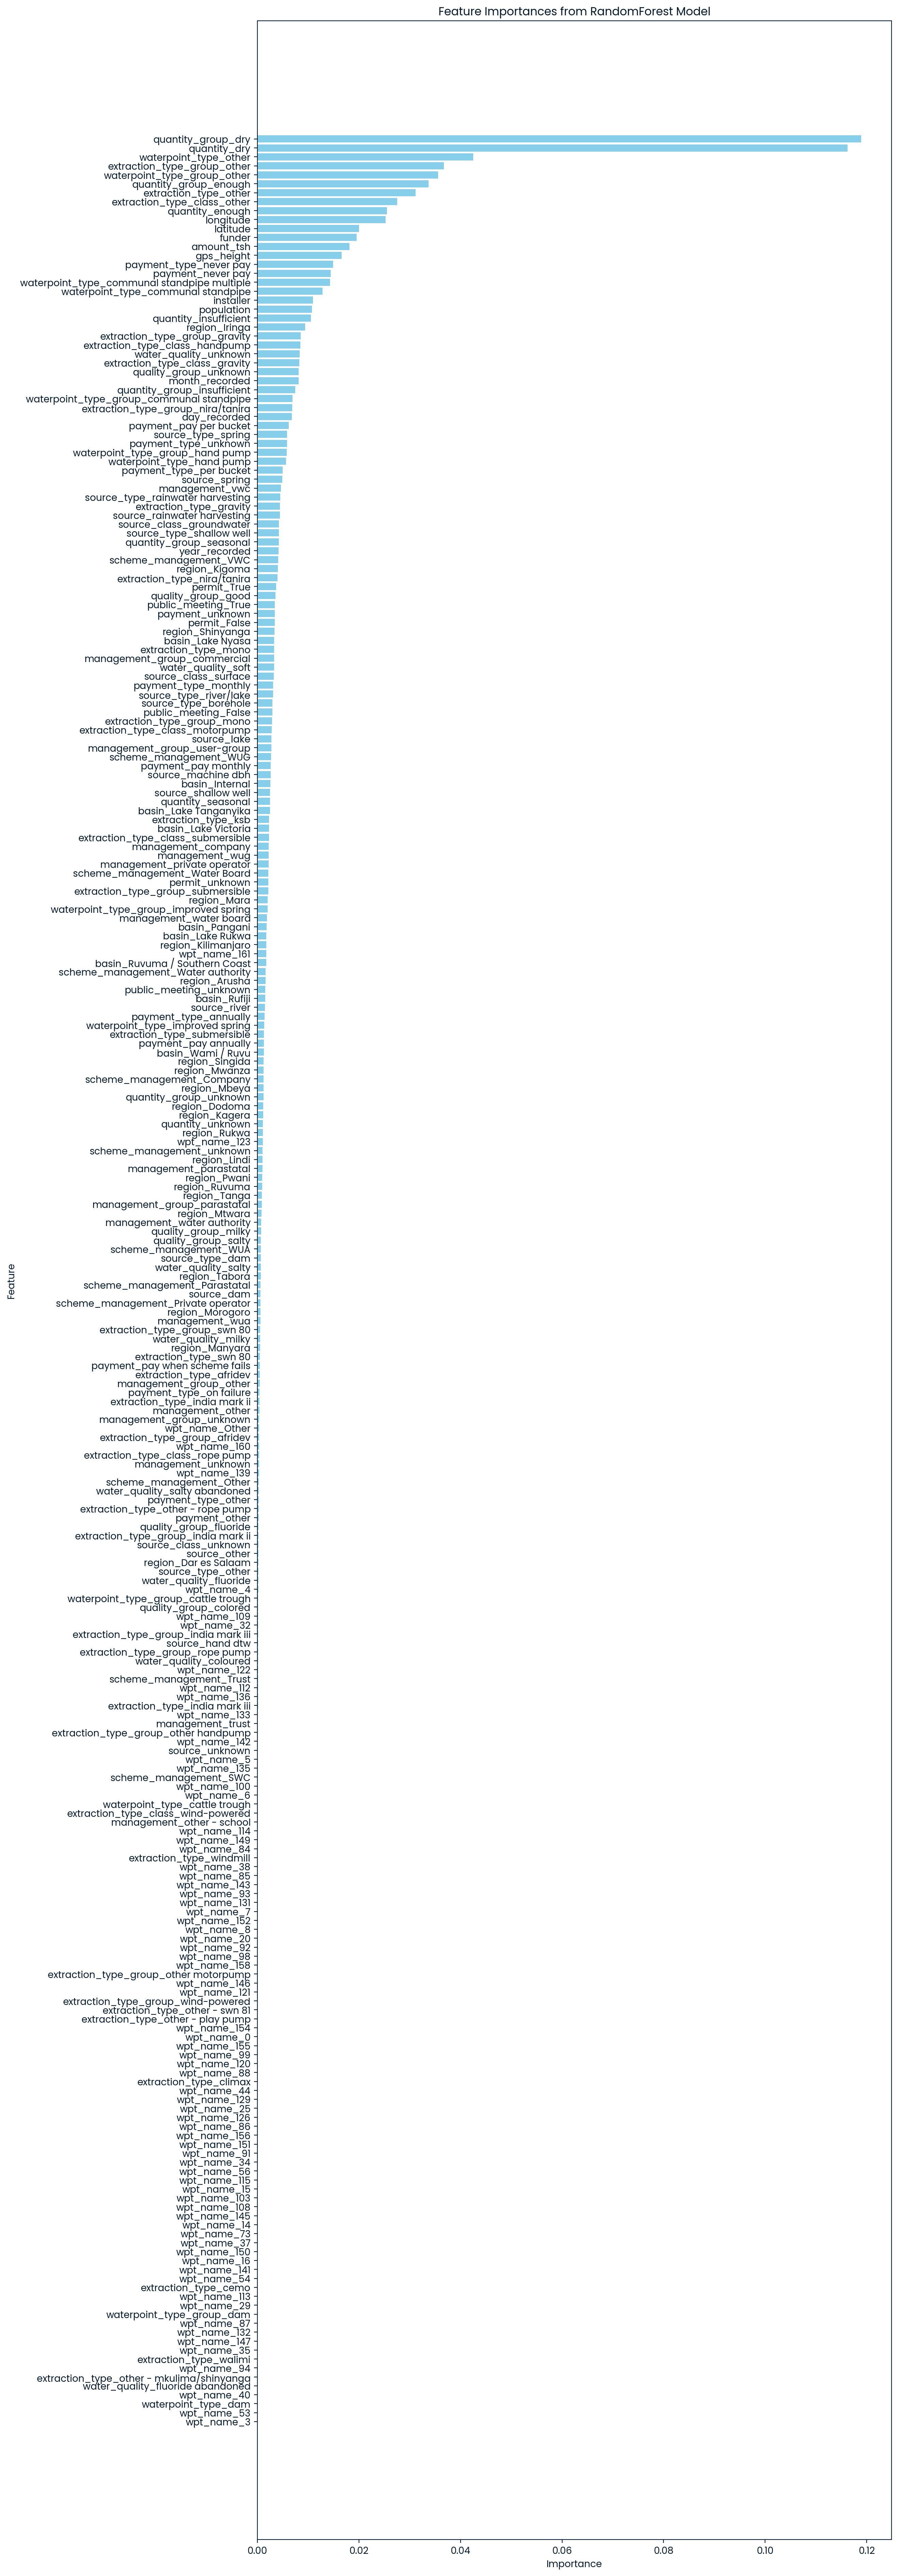

In [55]:
# Get feature importances from the RandomForest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': rf_feature_importances
})

# Sort the DataFrame by importance
rf_features_df = rf_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 48))
plt.barh(rf_features_df['Feature'], rf_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

In [54]:
%%time
# Ensure that categorical_columns only contains valid column names present in X_train_final
valid_categorical_columns = [col for col in categorical_columns if col in X_train_final.columns]

# CatBoostClassifier with depth=10
catboost_model = CatBoostClassifier(random_state=42, verbose=0, depth=10)
catboost_model.fit(X_train_final, y_train, cat_features=valid_categorical_columns)
catboost_preds = catboost_model.predict(X_test_final)
print("CatBoost Classification Report:\n", classification_report(y_test, catboost_preds))

CatBoost Classification Report:
                          precision    recall  f1-score   support

             functional       0.78      0.91      0.84      9678
functional needs repair       0.60      0.25      0.36      1295
         non functional       0.84      0.74      0.79      6847

               accuracy                           0.80     17820
              macro avg       0.74      0.63      0.66     17820
           weighted avg       0.79      0.80      0.78     17820

CPU times: user 8min 53s, sys: 20.2 s, total: 9min 13s
Wall time: 1min 17s


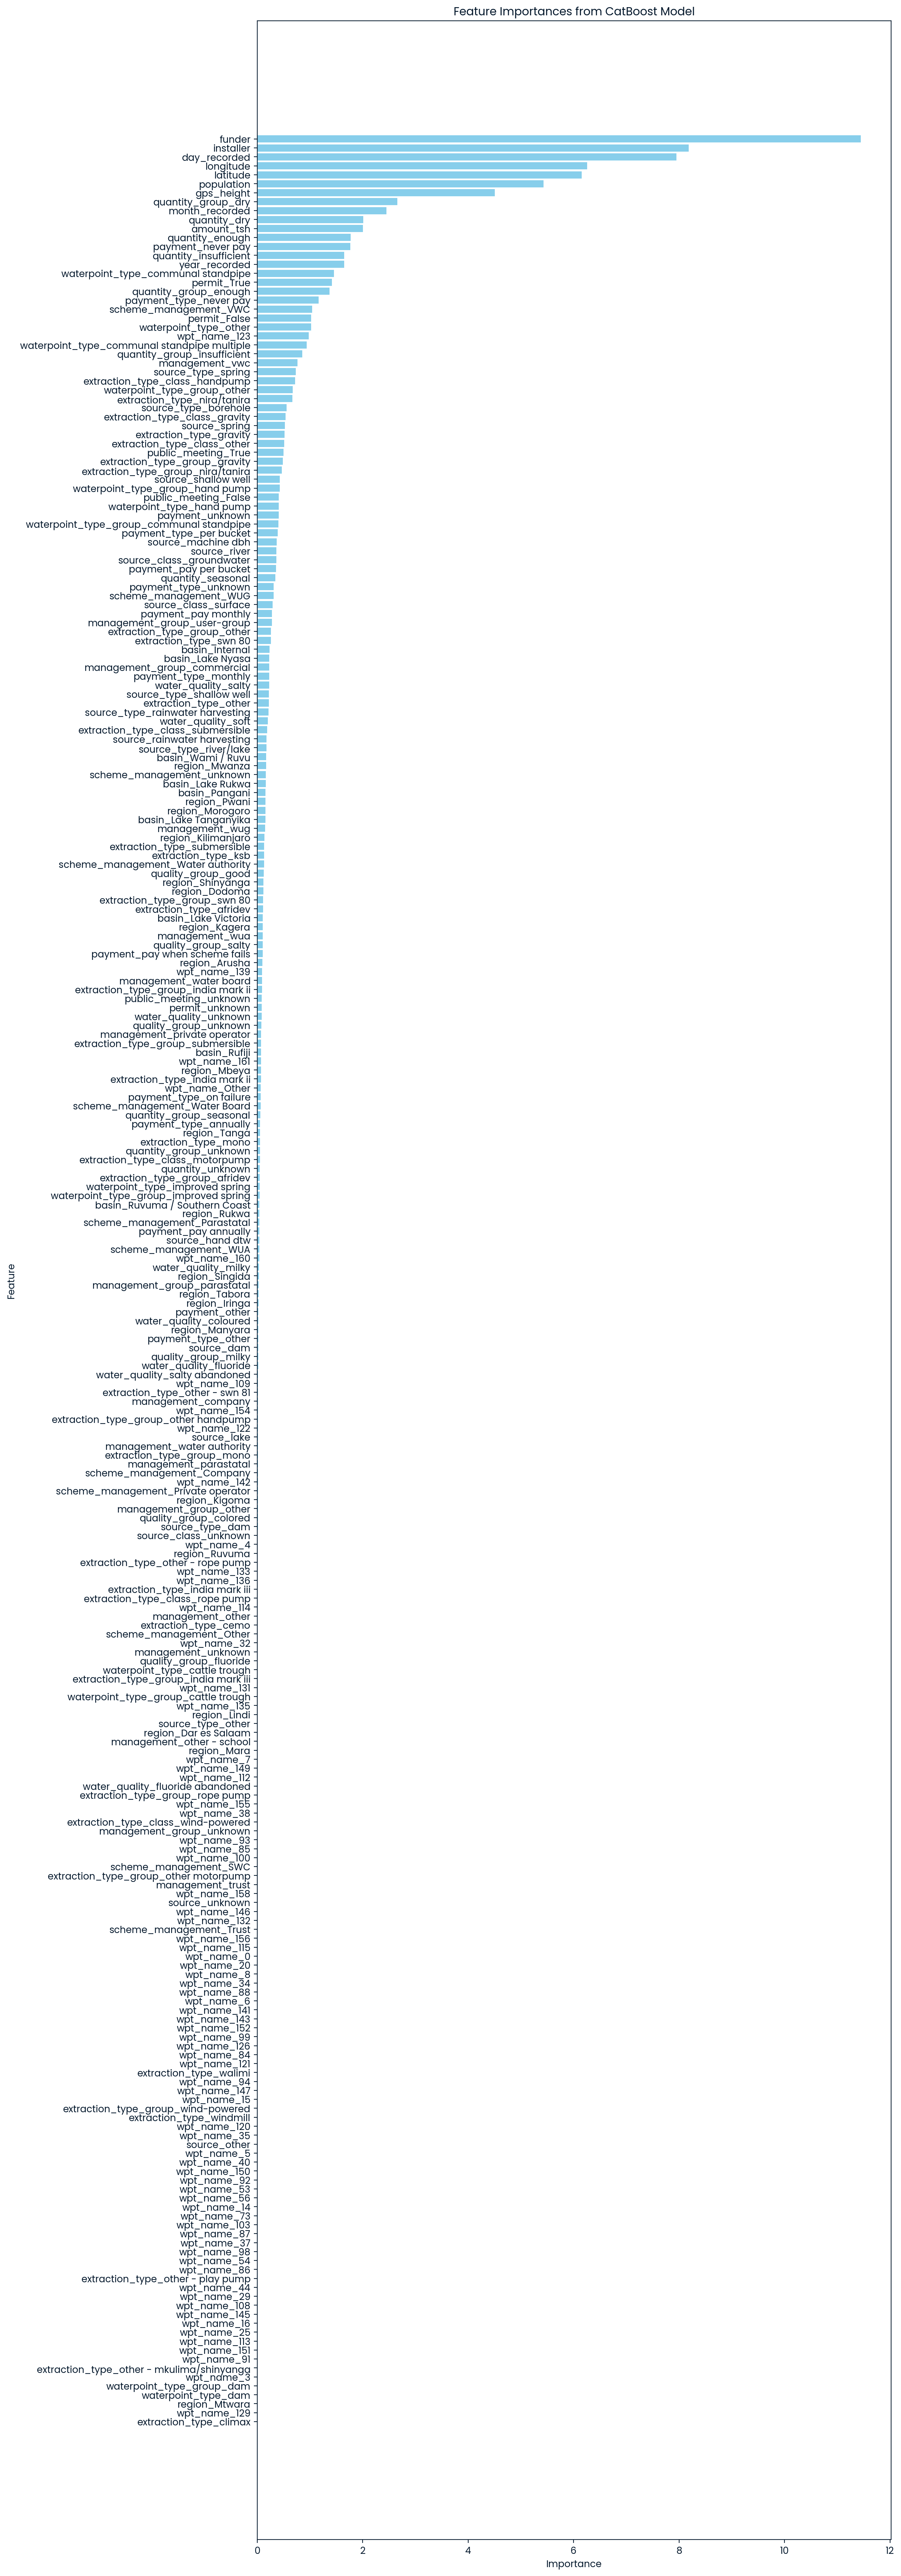

In [56]:
# Get feature importances from the CatBoost model
cb_feature_importances = catboost_model.get_feature_importance()

# Create a DataFrame for better visualization
cb_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': cb_feature_importances
})

# Sort the DataFrame by importance
cb_features_df = cb_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 48))
plt.barh(cb_features_df['Feature'], cb_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [57]:
%%time
# DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_final, y_train)
dt_preds = dt_model.predict(X_test_final)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_preds))

Decision Tree Classification Report:
                          precision    recall  f1-score   support

             functional       0.70      0.94      0.80      9678
functional needs repair       0.61      0.14      0.23      1295
         non functional       0.85      0.56      0.67      6847

               accuracy                           0.73     17820
              macro avg       0.72      0.54      0.57     17820
           weighted avg       0.75      0.73      0.71     17820

CPU times: user 1.1 s, sys: 20 ms, total: 1.12 s
Wall time: 1.11 s


In [58]:
%%time
# LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42, max_depth=10)
lgbm_model.fit(X_train_final, y_train, categorical_feature='auto')
lgbm_preds = lgbm_model.predict(X_test_final)
print("LGBM Classification Report:\n", classification_report(y_test, lgbm_preds))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 41580, number of used features: 252
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.621700
[LightGBM] [Info] Start training from score -0.956469
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LGBM Classific

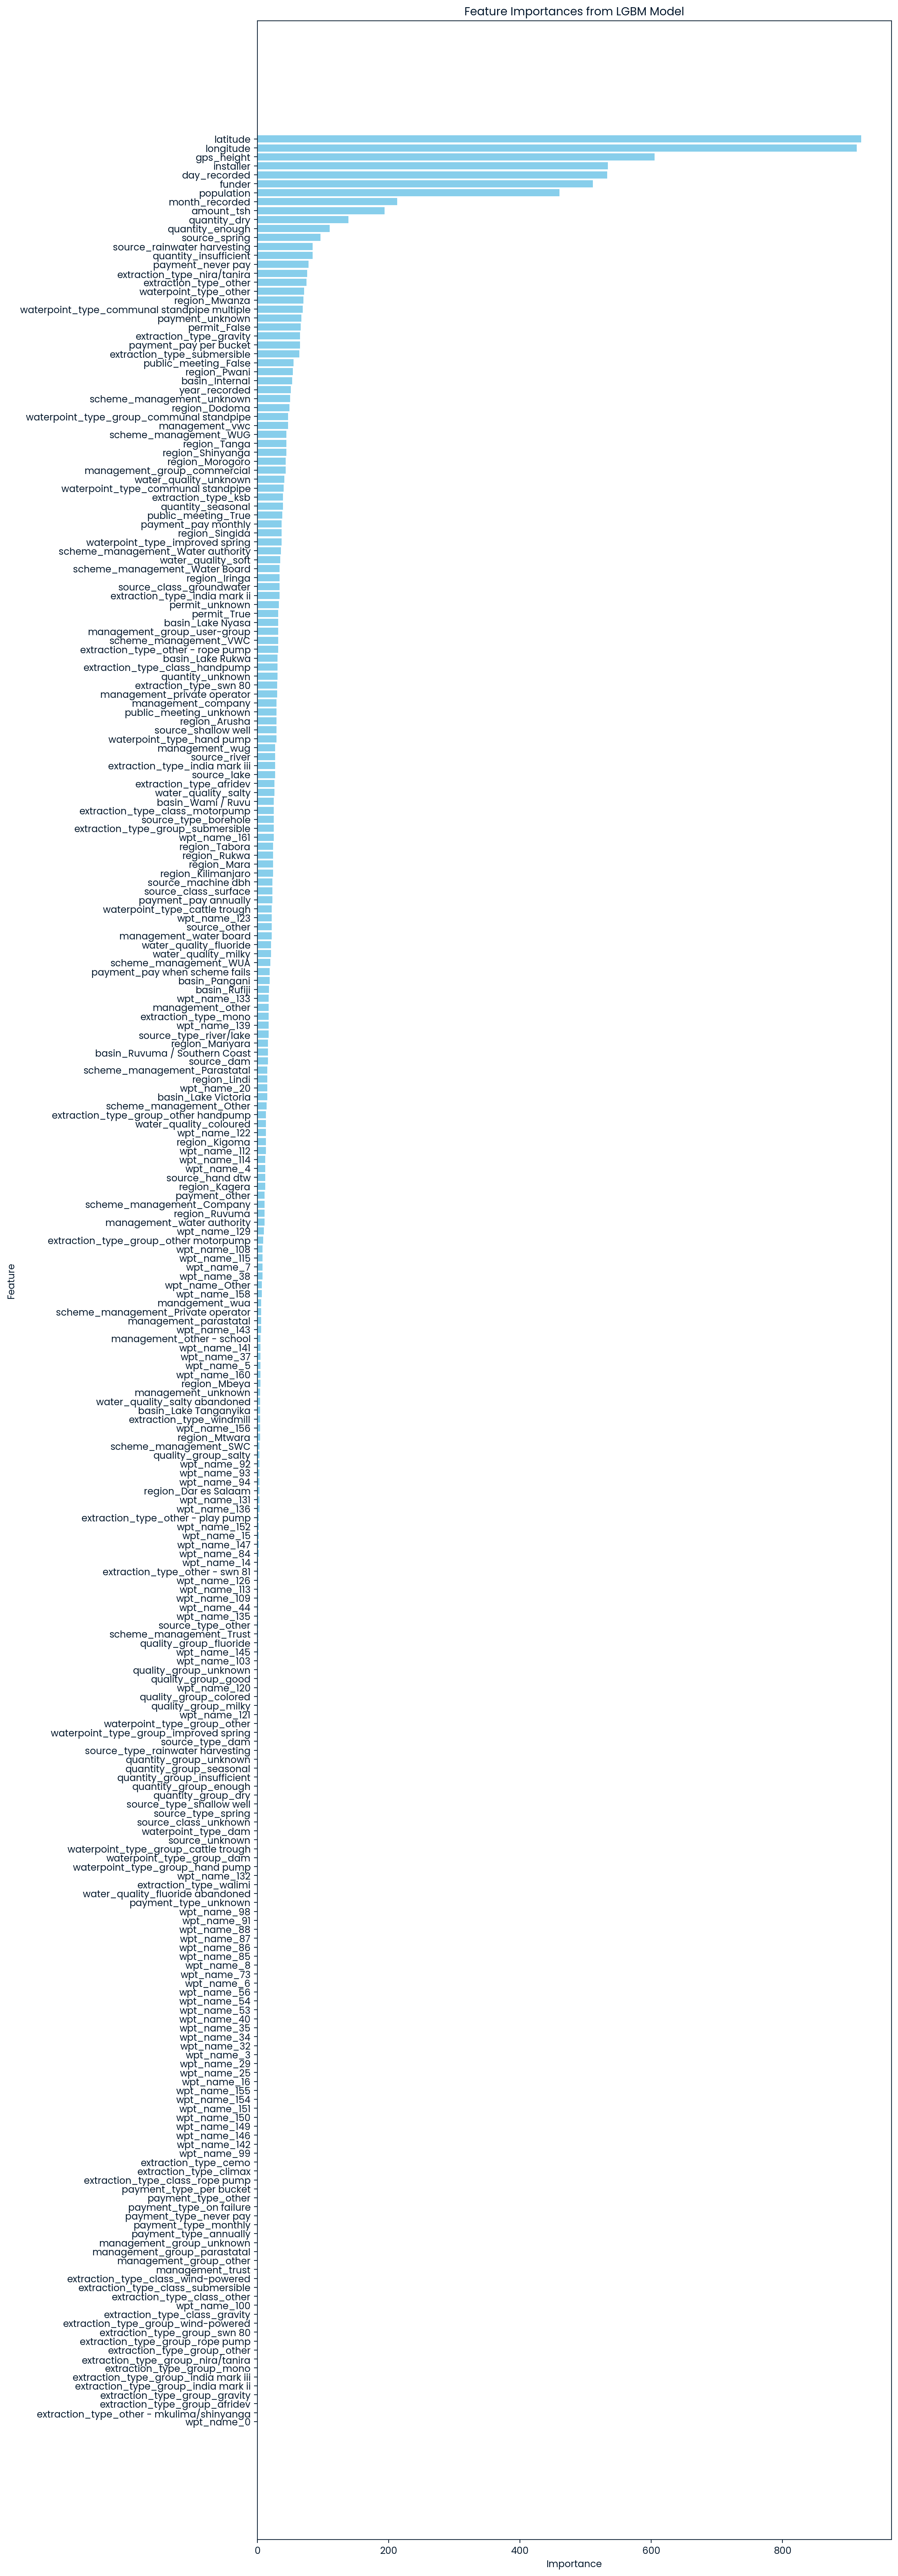

In [59]:
# Get feature importances from the LGBM model
lgbm_feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
lgbm_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': lgbm_feature_importances
})

# Sort the DataFrame by importance
lgbm_features_df = lgbm_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 48))
plt.barh(lgbm_features_df['Feature'], lgbm_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [60]:
# Extracting the classification reports
rf_report = classification_report(y_test, rf_preds, output_dict=True)
catboost_report = classification_report(y_test, catboost_preds, output_dict=True)
dt_report = classification_report(y_test, dt_preds, output_dict=True)
lgbm_report = classification_report(y_test, lgbm_preds, output_dict=True)

# Creating a summary dataframe with rounded values
summary_df = pd.DataFrame({
    'Model': ['Random Forest', 'CatBoost', 'Decision Tree', 'LGBM'],
    'Accuracy': [round(rf_report['accuracy'], 4),
                 round(catboost_report['accuracy'], 4),
                 round(dt_report['accuracy'], 4),
                 round(lgbm_report['accuracy'], 4)],
    'Precision (macro avg)': [round(rf_report['macro avg']['precision'], 4),
                              round(catboost_report['macro avg']['precision'], 4), 
                              round(dt_report['macro avg']['precision'], 4), 
                              round(lgbm_report['macro avg']['precision'], 4)],
    'Recall (macro avg)': [round(rf_report['macro avg']['recall'], 4), 
                           round(catboost_report['macro avg']['recall'], 4), 
                           round(dt_report['macro avg']['recall'], 4), 
                           round(lgbm_report['macro avg']['recall'], 4)],
    'F1-Score (macro avg)': [round(rf_report['macro avg']['f1-score'], 4), 
                             round(catboost_report['macro avg']['f1-score'], 4), 
                             round(dt_report['macro avg']['f1-score'], 4), 
                             round(lgbm_report['macro avg']['f1-score'], 4)]
})

summary_df

Model  Accuracy  ...  Recall (macro avg)  F1-Score (macro avg)
0  Random Forest    0.7446  ...              0.5282                0.5346
1       CatBoost    0.7958  ...              0.6338                0.6611
2  Decision Tree    0.7322  ...              0.5437                0.5653
3           LGBM    0.7772  ...              0.5978                0.6246

[4 rows x 5 columns]

In [61]:
# Predict using RandomForest model
rf_test_preds = rf_model.predict(test_features_final)

# Replace values in 'status_group' with rf_test_preds
submission['status_group'] = rf_test_preds

submission.to_csv('submission_rf3.csv', index=False)

In [62]:
# Predict using CatBoost model
catboost_test_preds = catboost_model.predict(test_features_final)

# Ensure catboost_test_preds is a 1-dimensional array
catboost_test_preds = catboost_test_preds.flatten()

# Replace values in 'status_group' with catboost_test_preds
submission['status_group'] = catboost_test_preds

submission.to_csv('submission_catboost3.csv', index=False)

In [63]:
# Predict using LGBM model
lgbm_test_preds = lgbm_model.predict(test_features_final)

submission['status_group'] = lgbm_test_preds

submission.to_csv('submission_lgbm3.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
